In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Volatility Forecasting

## Explaining stock returns' volatility with ARCH models

1. Import the libraries:

In [3]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import yfinance as yf
from arch import arch_model

2. Specify the risky asset and the time horizon:

In [5]:
RISKY_ASSET = 'GOOG'
START_DATE = '2015-01-01'
END_DATE = '2020-12-31'

3. Download data from Yahoo Finance:

In [6]:
df = yf.download(RISKY_ASSET,
                start=START_DATE,
                end=END_DATE,
                adjusted=True)

print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  1 of 1 completed
Downloaded 1511 rows of data.


4. Calculate daily returns:

Average return: 0.09%


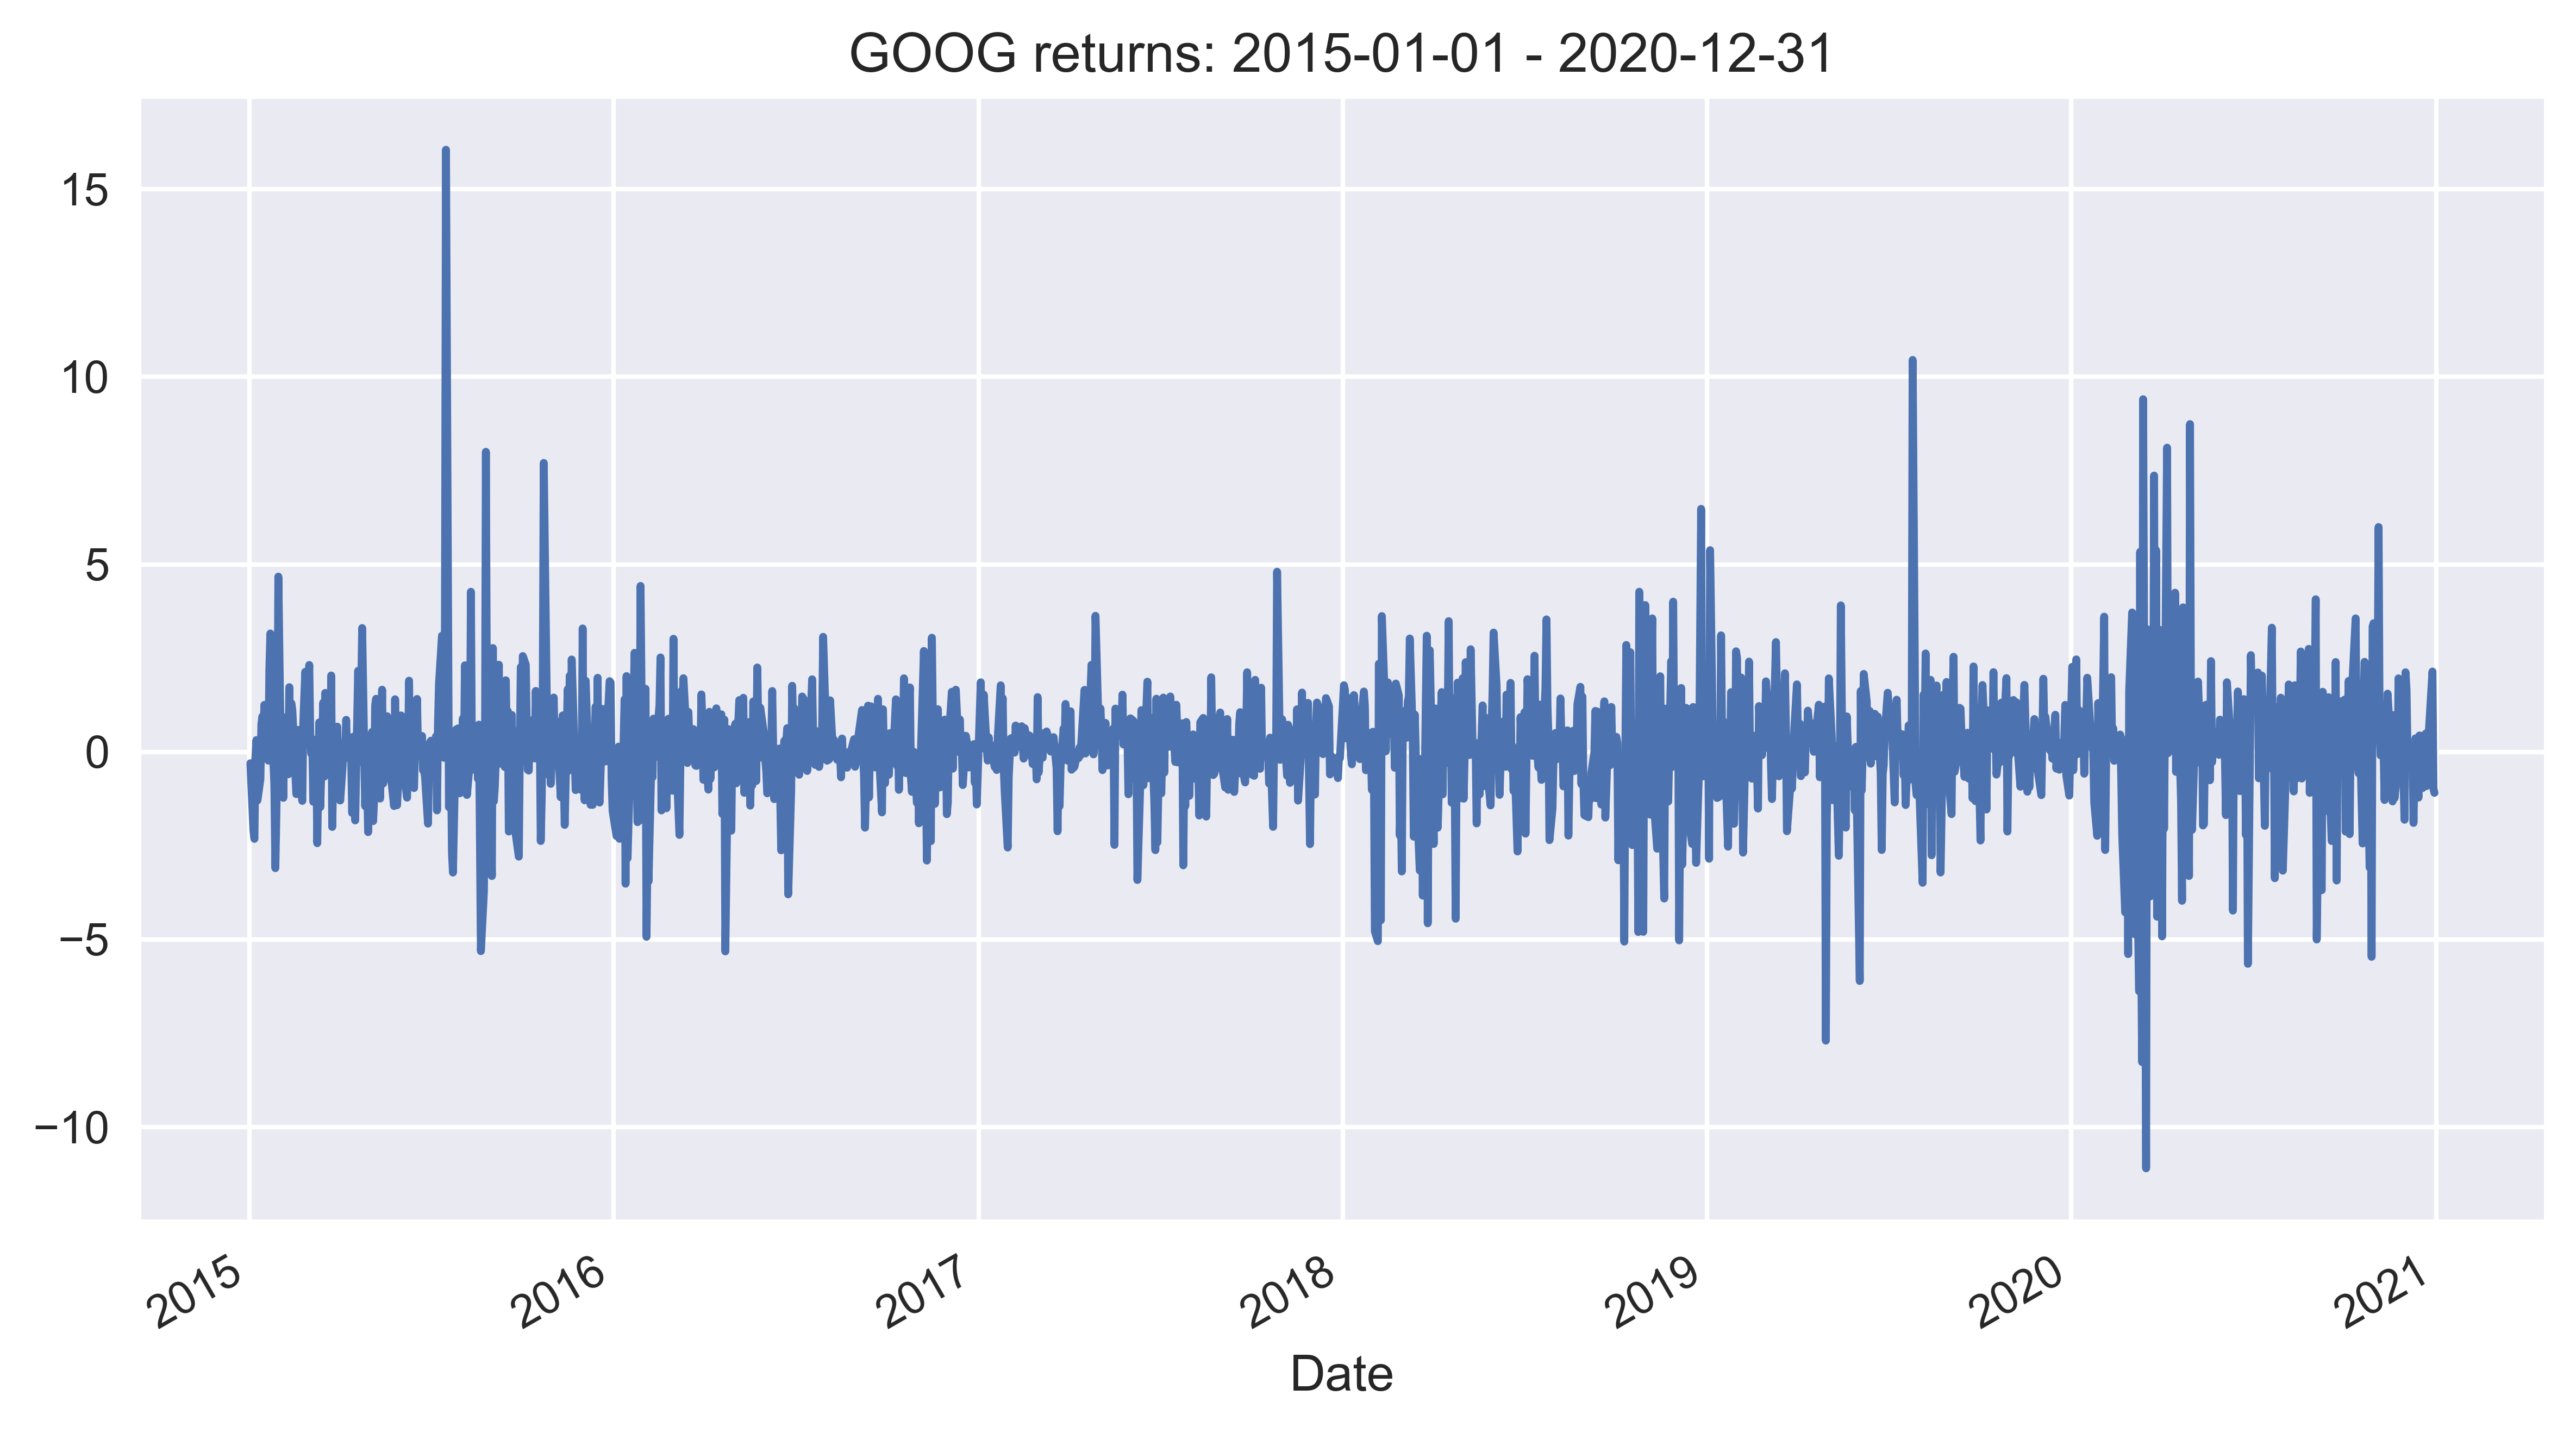

In [7]:
returns = 100 * df['Adj Close'].pct_change().dropna()
returns.name = 'asset_returns'
print(f'Average return: {round(returns.mean(), 2)}%')
returns.plot(title=f'{RISKY_ASSET} returns: {START_DATE} - {END_DATE}');

plt.tight_layout()
plt.show()

5. Specify the ARCH model:

In [8]:
model = arch_model(returns, mean='Zero', vol='ARCH', p=1, o=0, q=0)

6. Estimate the model and print the summary:

In [9]:
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -2841.28
Distribution:                  Normal   AIC:                           5686.56
Method:            Maximum Likelihood   BIC:                           5697.20
                                        No. Observations:                 1510
Date:                Thu, Dec 16 2021   Df Residuals:                     1510
Time:                        12:00:53   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.8524      0.184     10.067  7.711e-24 [  1.492,  2.21

7. Plot the residuals and the conditional volatility:

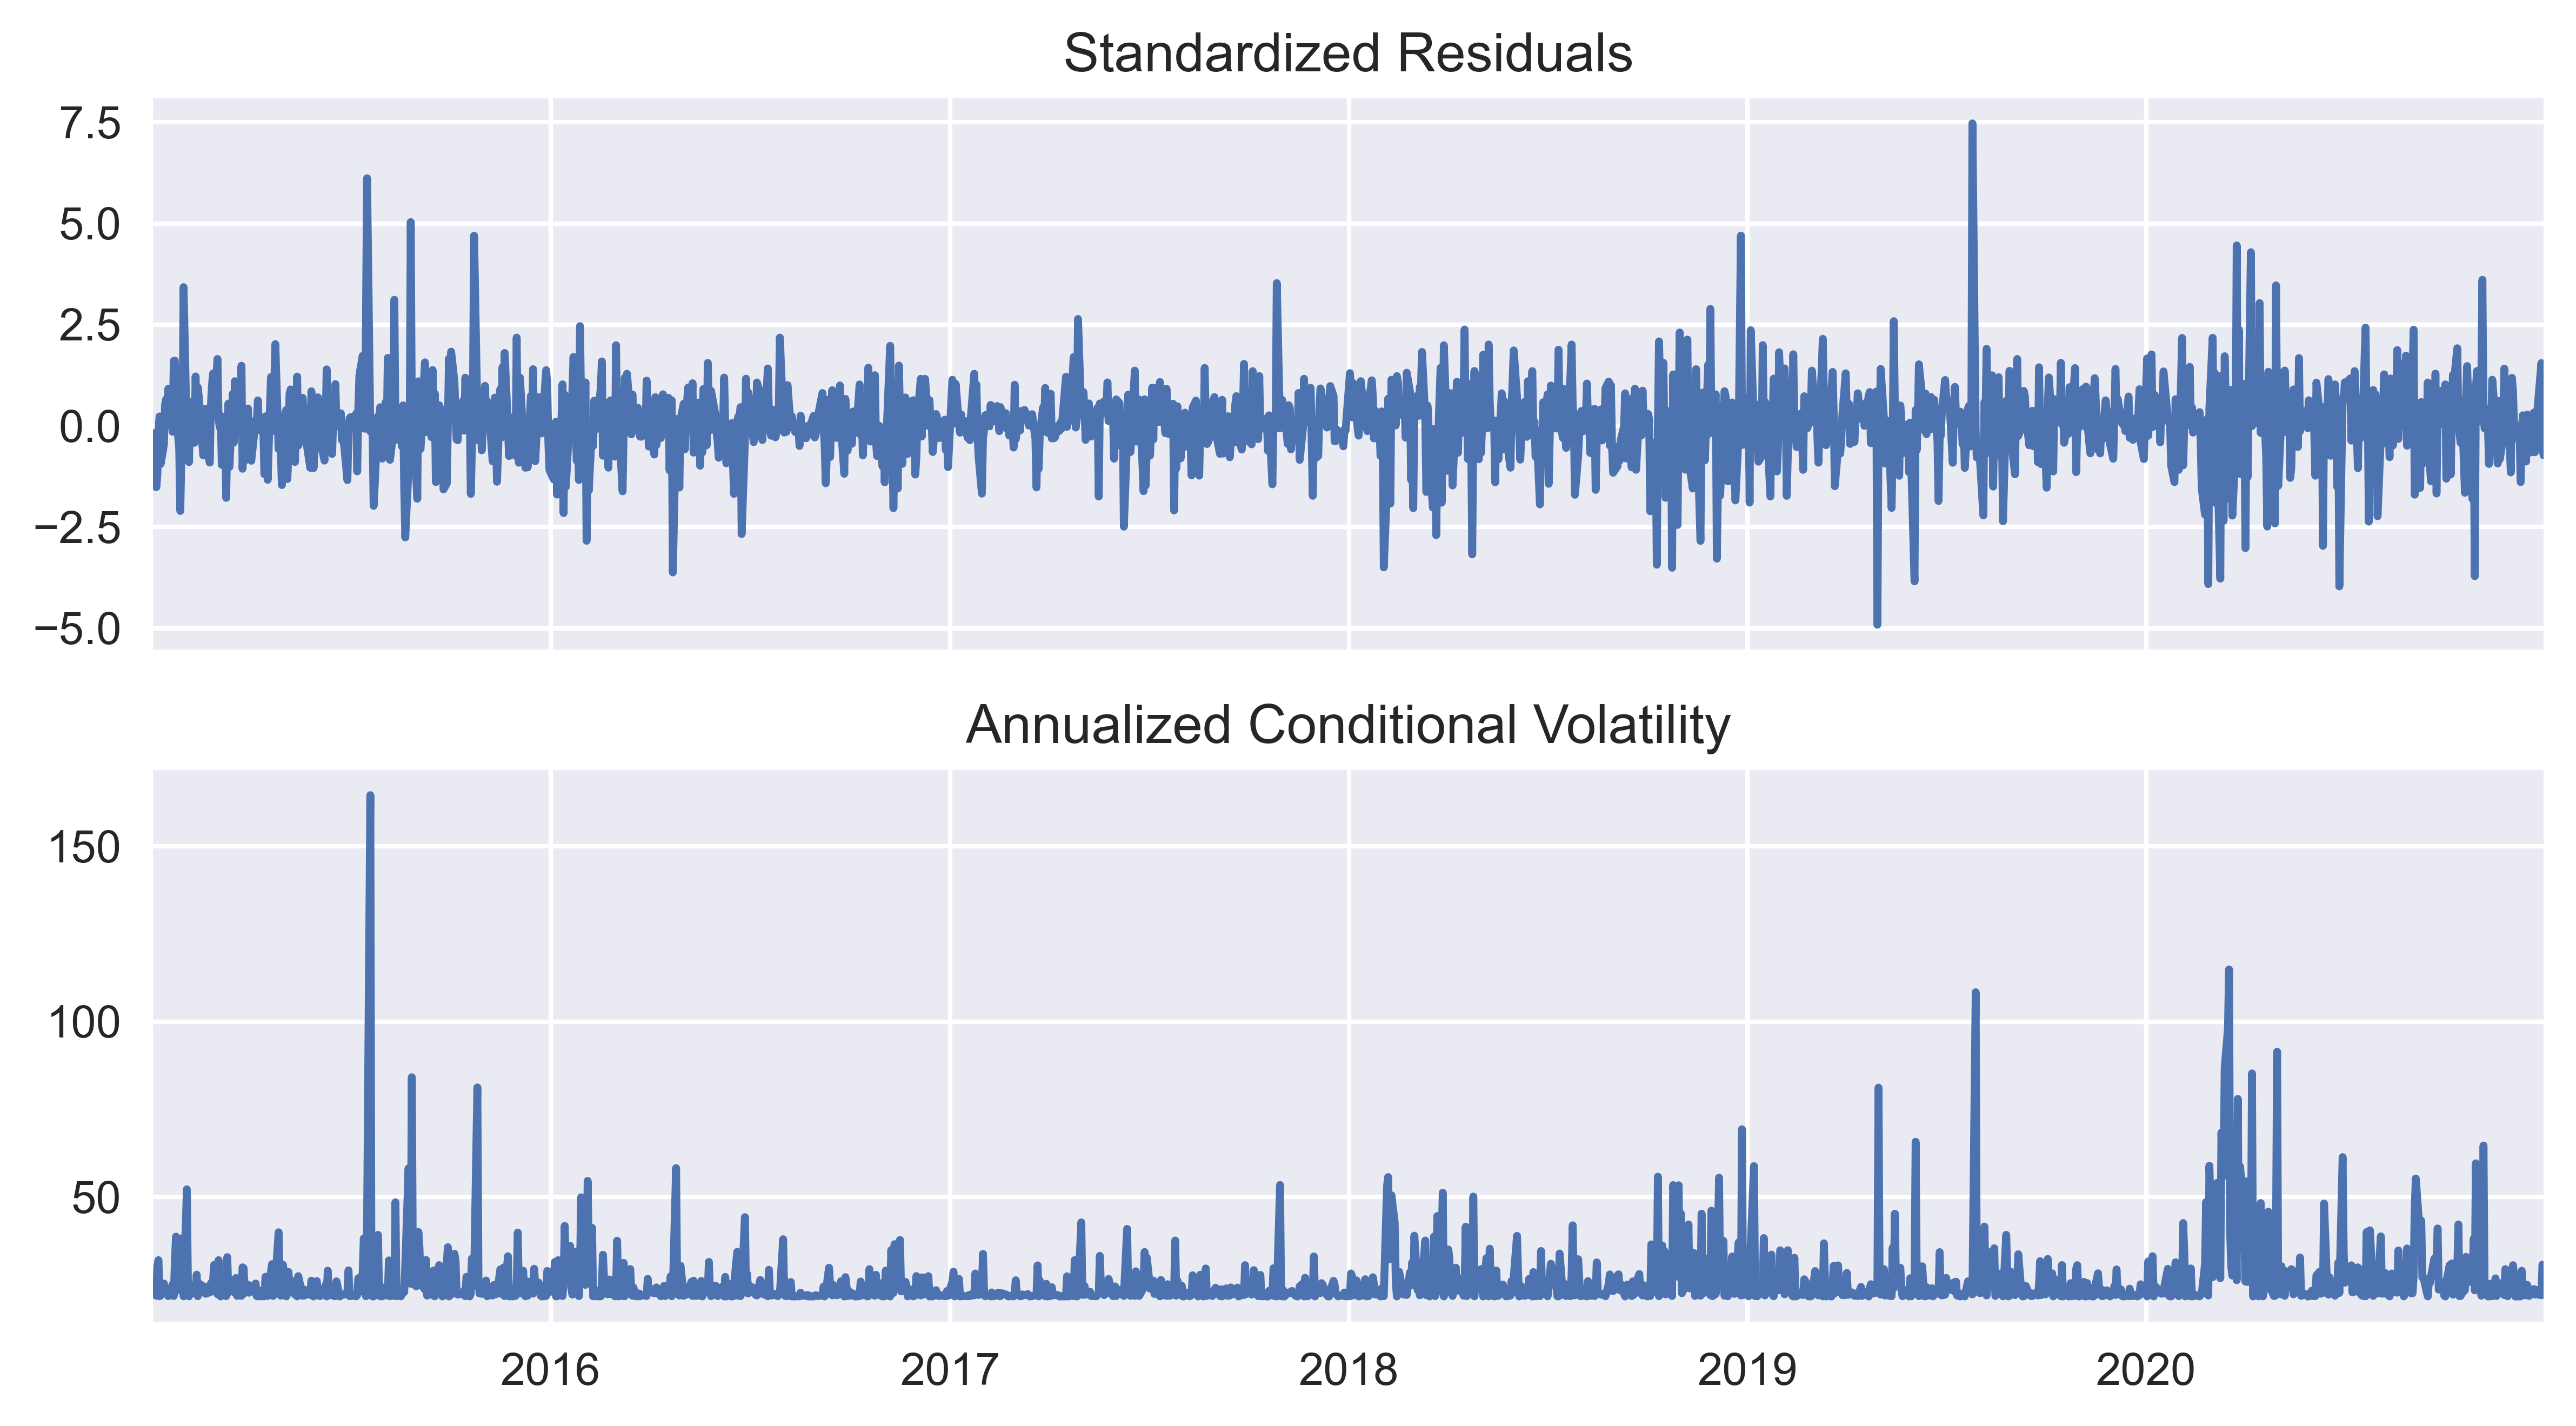

In [10]:
model_fitted.plot(annualize='D')

plt.tight_layout()
plt.show()

## Explaining stock returns' volatility with GARCH models

1. Specify the GARCH model:

In [11]:
model = arch_model(returns, mean='Zero', vol='GARCH', 
                  p=1, o=0, q=1)

2. Estimate the model and print the summary:

In [12]:
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2793.07
Distribution:                  Normal   AIC:                           5592.14
Method:            Maximum Likelihood   BIC:                           5608.10
                                        No. Observations:                 1510
Date:                Thu, Dec 16 2021   Df Residuals:                     1510
Time:                        12:00:55   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2936      0.202      1.457      0.145    [ -

3. Plot the residuals and the conditional volatility:

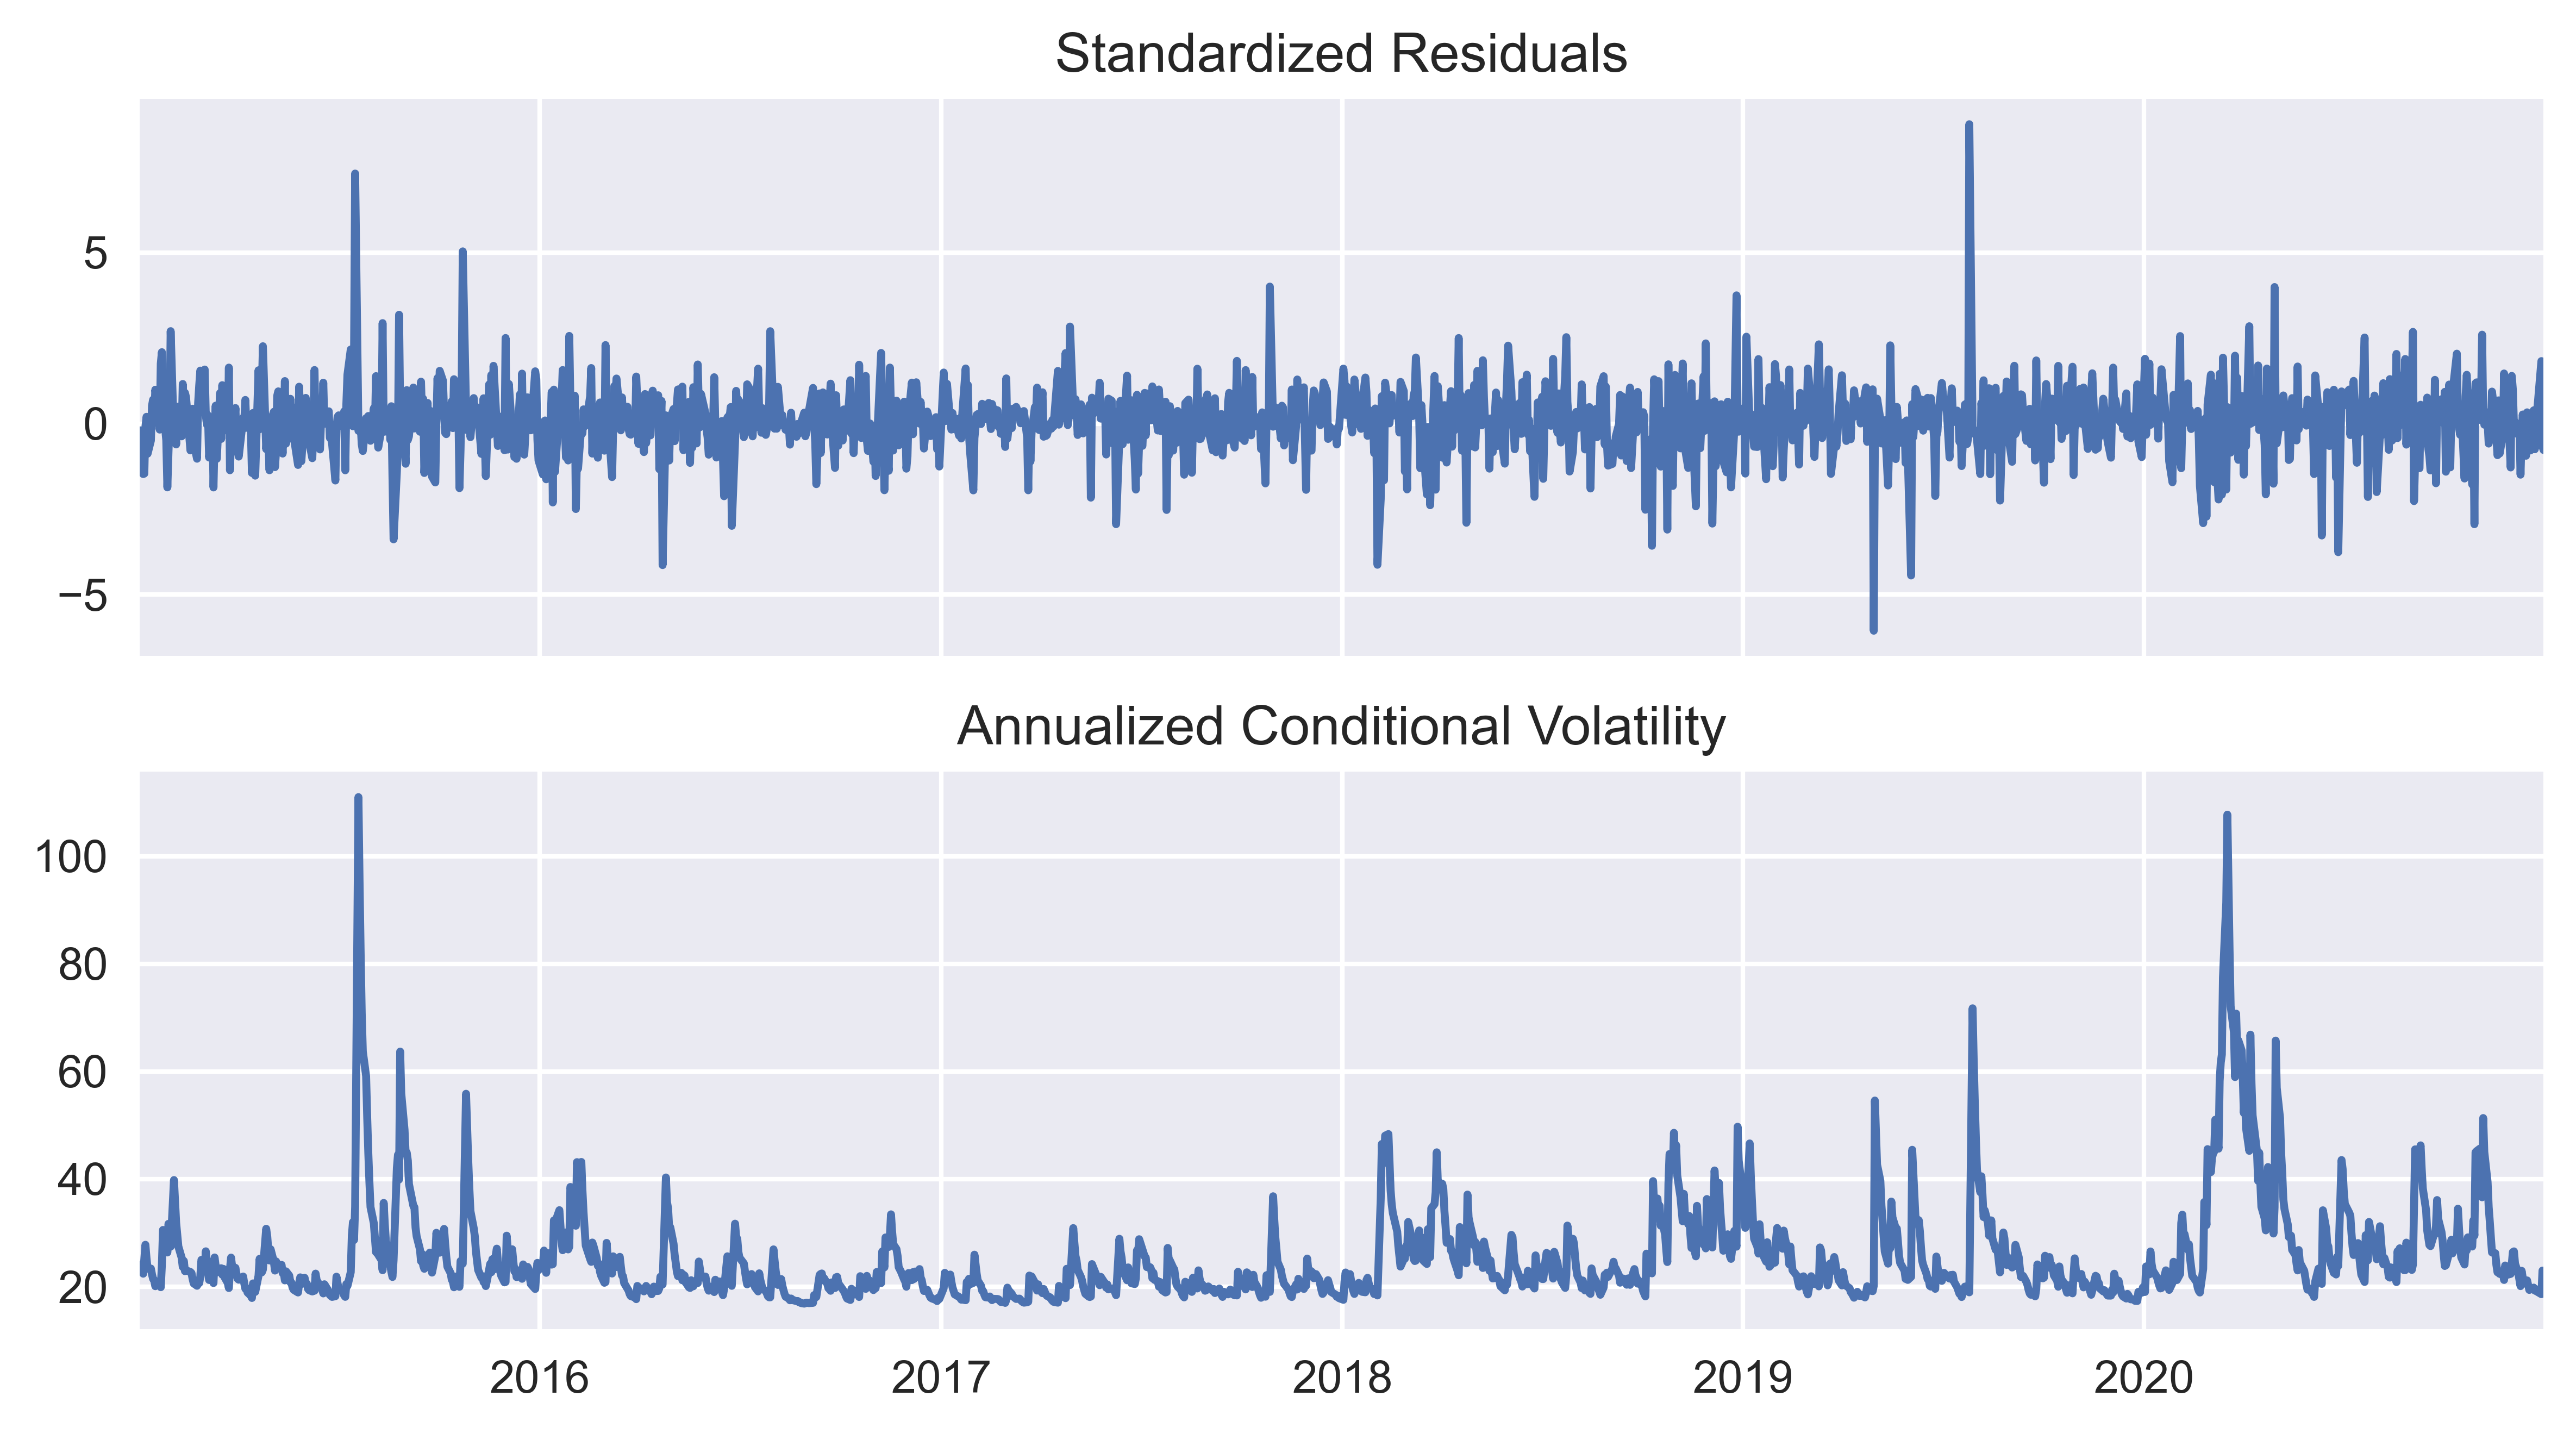

In [13]:
model_fitted.plot(annualize='D')

plt.tight_layout()
plt.show()

## Implementing CCC-GARCH model for multivariate volatility forecasting

1. Import the libraries:

In [14]:
import pandas as pd
import yfinance as yf
from arch import arch_model
import numpy as np

2. Specify the risky asset and the time horizon:

In [15]:
RISKY_ASSETS = ['GOOG', 'MSFT', 'AAPL']
N = len(RISKY_ASSETS)
START_DATE = '2015-01-01'
END_DATE = '2020-12-31'

3. Download data from Yahoo Finance:

In [16]:
df = yf.download(RISKY_ASSETS,
                start=START_DATE,
                end=END_DATE,
                adjusted=True)

print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  3 of 3 completed
Downloaded 1511 rows of data.


4. Calculate daily returns:

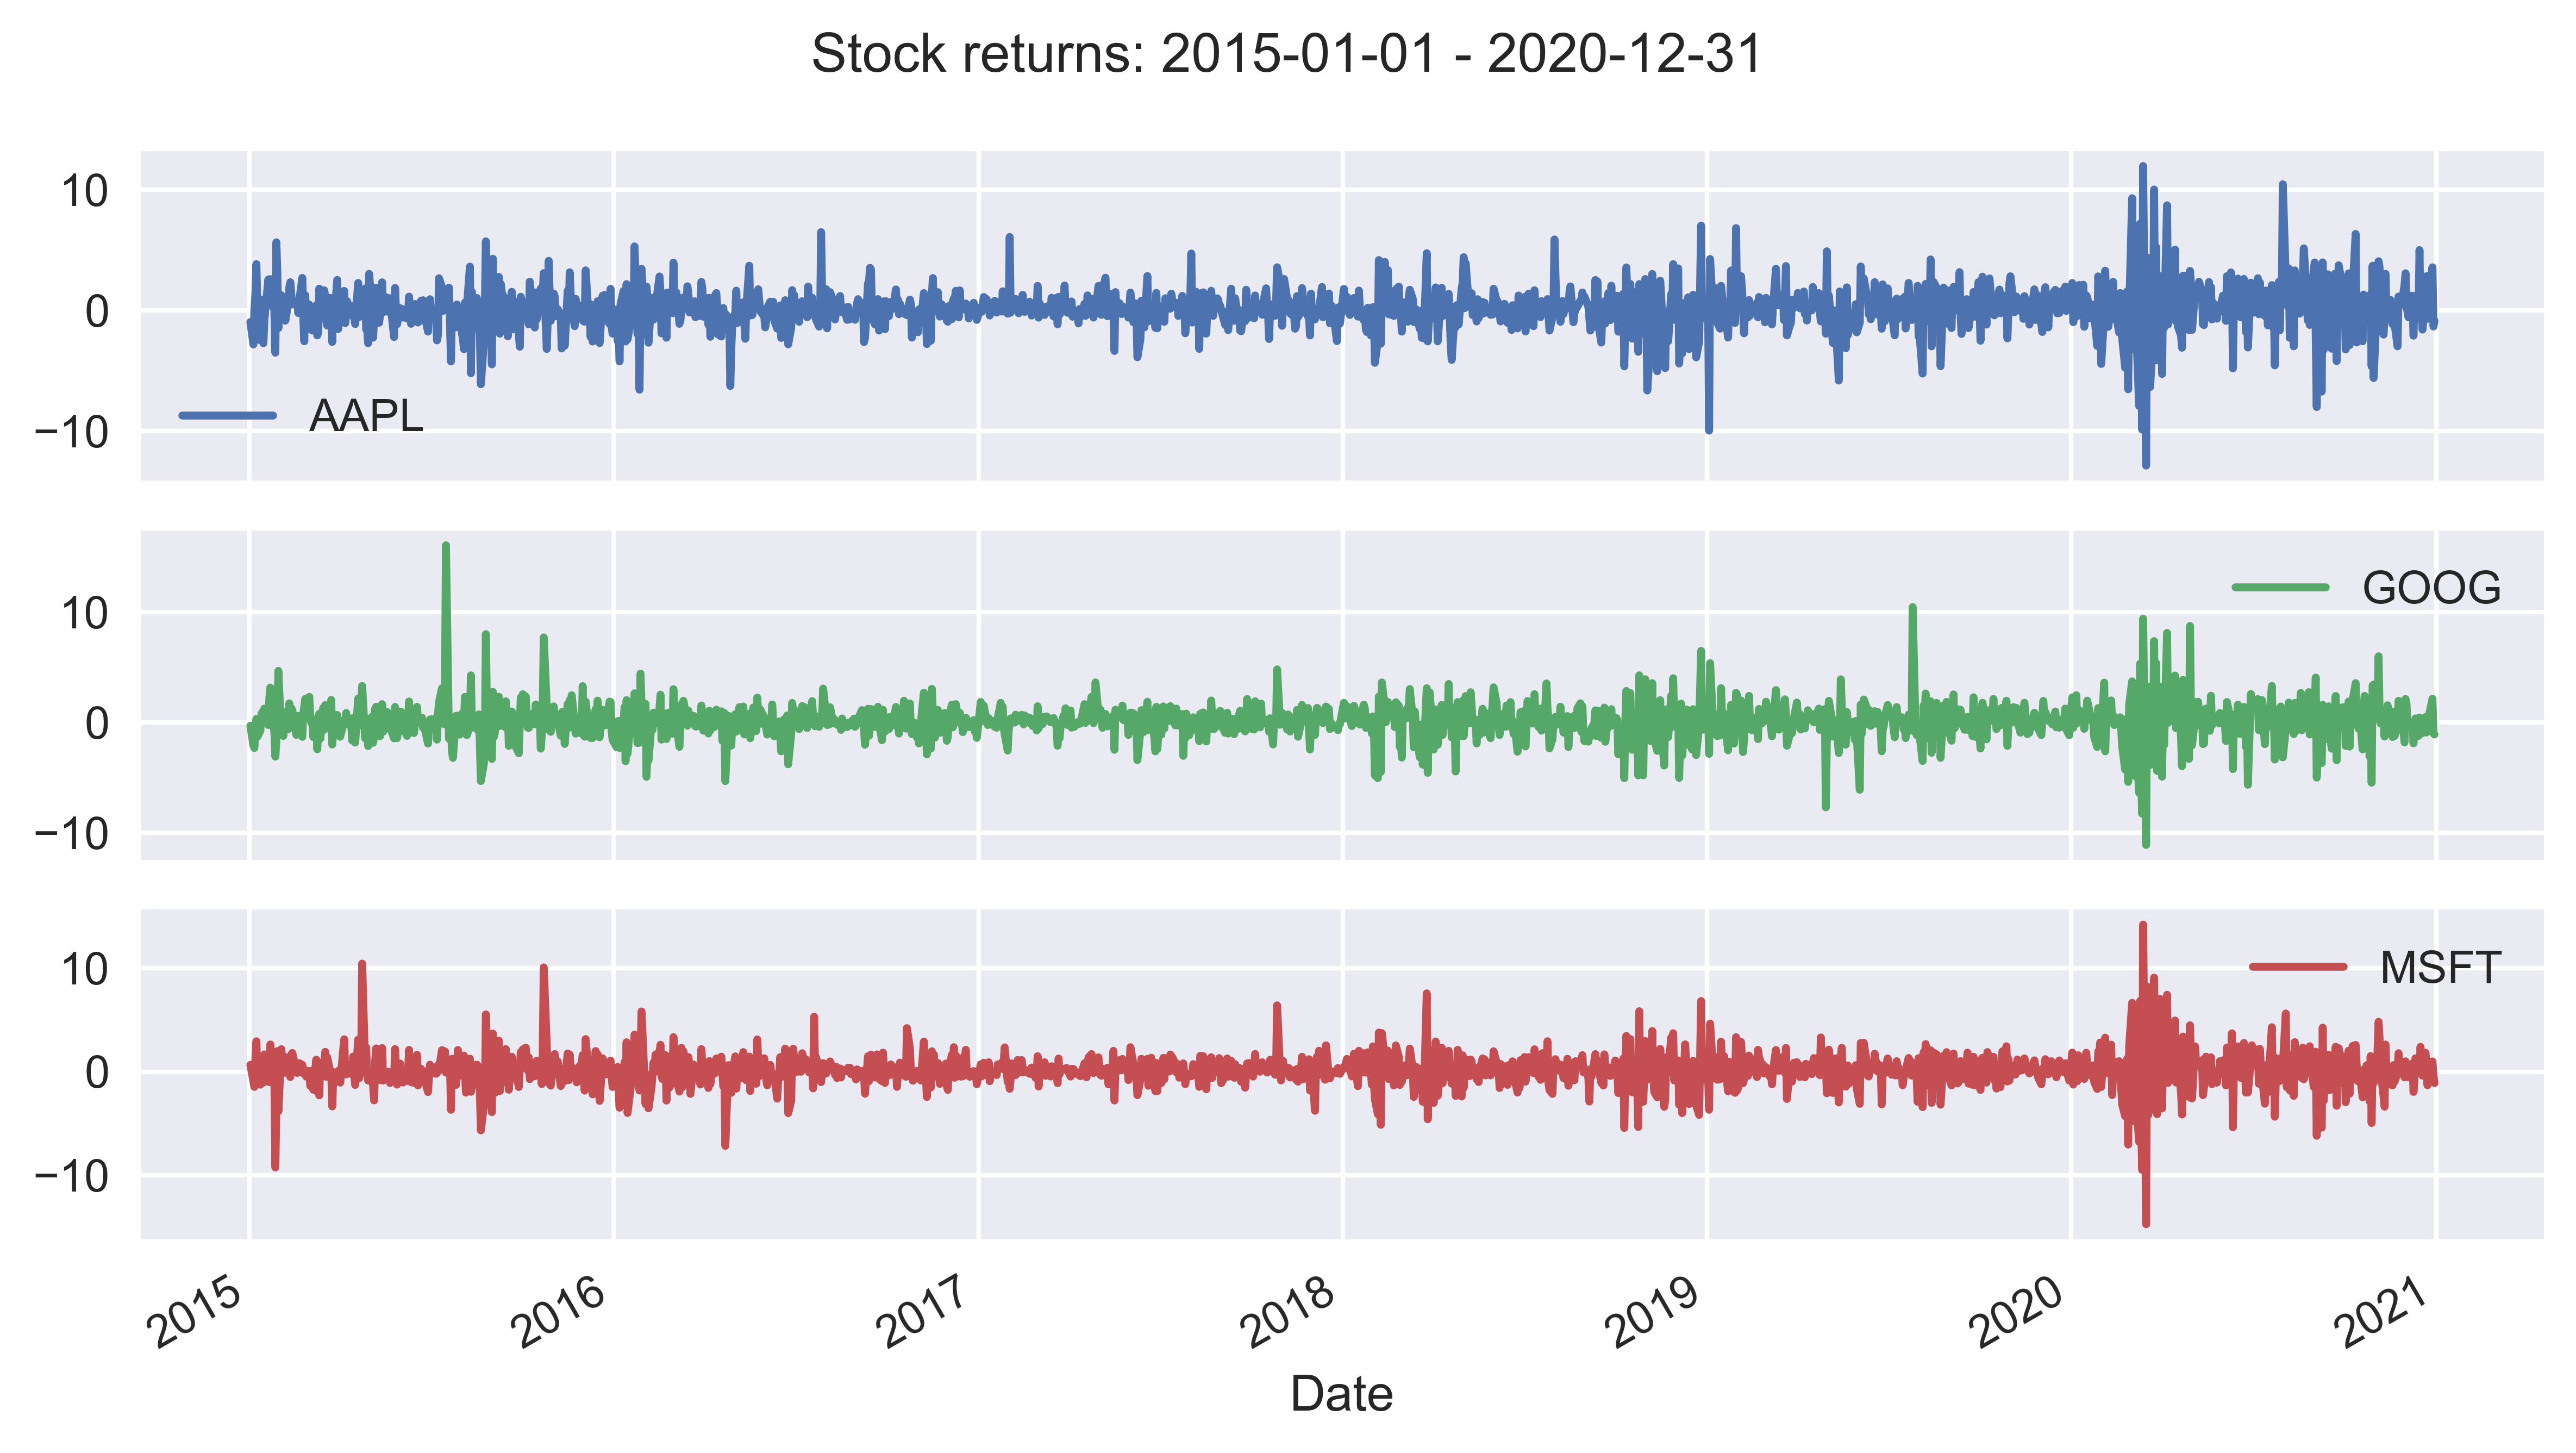

In [17]:
returns = 100 * df['Adj Close'].pct_change().dropna()
returns.plot(subplots=True, 
            title=f'Stock returns: {START_DATE} - {END_DATE}')

plt.tight_layout()
plt.show()

5. Define lists for storing objects:

In [18]:
coeffs = []
cond_vol = []
std_resids = []
models = []

6. Estimate the univariate GARCH models:

In [19]:
for asset in returns.columns:
    # specify and fit the model
    model = arch_model(returns[asset], mean='Constant', 
                      vol='GARCH', p=1, o=0, q=1).fit(update_freq=0, 
                                                     disp='off')
    # store results in the lists 
    coeffs.append(model.params)
    cond_vol.append(model.conditional_volatility)
    std_resids.append(model.resid / model.conditional_volatility)
    models.append(model)

7. Store the results in DataFrames:

In [20]:
coeffs_df = pd.DataFrame(coeffs, index=returns.columns)
cond_vol_df = pd.DataFrame(cond_vol).transpose() \
                .set_axis(returns.columns, 
                         axis='columns', 
                         inplace=False)
std_resids_df = pd.DataFrame(std_resids).transpose() \
                .set_axis(returns.columns, 
                         axis='columns', 
                         inplace=False)

In [21]:
coeffs_df

,mu,omega,alpha[1],beta[1]
AAPL,0.196093,0.180927,0.145505,0.803447
GOOG,0.117260,0.322269,0.193567,0.704221
MSFT,0.140648,0.269207,0.231541,0.693436


8. Calculate the constant conditional correlation matrix (R):

In [22]:
R = std_resids_df.transpose() \
                 .dot(std_resids_df) \
                 .div(len(std_resids_df))

9. Calculate the 1-step ahead forecast of the conditional covariance matrix :

In [23]:
# define objects
diag = []
D = np.zeros((N, N))

# populate the list with conditional variances
for model in models:
    diag.append(model.forecast(horizon=1).variance.values[-1][0])
# take the square root to obtain volatility from variance
diag = np.sqrt(np.array(diag))
# fill the diagonal of D with values from diag
np.fill_diagonal(D, diag)
    
# calculate the conditional covariance matrix
H = np.matmul(np.matmul(D, R.values), D)

In [24]:
H

array([[3.47177307, 1.38405145, 1.31286591],
       [1.38405145, 2.02897155, 1.20112897],
       [1.31286591, 1.20112897, 1.64230536]])

## Forecasting the conditional covariance matrix using DCC-GARCH (Using Python and R)

1. Import the libraries:

In [25]:
import pandas as pd

In [26]:
%load_ext rpy2.ipython

ModuleNotFoundError: No module named 'rpy2'

2. Install `rmgarch` R package (run only once) and load it:

In [ ]:
%%R

#install.packages('rmgarch', repos = "http://cran.us.r-project.org")
library(rmgarch)

3. Import the dataset into R:

In [ ]:
%%R

read.csv("C:/Program Files/R/R-4.0.5/returns.csv")
print(head(returns, 5))

4. Define the model specification:

In [ ]:
%%R

# define GARCH(1,1) model
univariate_spec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                             variance.model = list(garchOrder = c(1,1), 
                                                  model = "sGARCH"),
                             distribution.model = "norm")

# define DCC(1,1) model
n <- dim(returns)[2]
dcc_spec <- dccspec(uspec = multispec(replicate(n, univariate_spec)),
                   dccOrder = c(1,1),
                   distribution = "mvnorm")

dcc_spec

5. Estimate the model:

In [ ]:
%%R
dcc_fit <- dccfit(dcc_spec, data=returns)
dcc_fit

6. Calculate the 5-step ahead forecasts:

In [ ]:
%%R

forecasts <- dccforecast(dcc_fit, n.ahead = 5)
forecasts

7. Access the forecasts:

In [ ]:
%%R

# conditional covariance matrix
forecasts@mforecast$H
# conditional correlation matrix
forecasts@mforecast$R
# proxy correlation process
forecasts@mforecast$Q
# conditional mean forecasts
forecasts@mforecast$mu